[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/09-nonlinear-methods/neural-networks-hyperparameter-tuning.ipynb)

In [1]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

downloading uv 0.10.2 aarch64-apple-darwin
no checksums to verify
installing to /Users/jkitchin/.local/bin
  uv
  uvx
everything's installed!
error: The interpreter at /opt/homebrew/opt/python@3.14/Frameworks/Python.framework/Versions/3.14 is externally managed, and indicates the following:

  To install Python packages system-wide, try brew install
  xyz, where xyz is the package you are trying to
  install.

  If you wish to install a Python library that isn't in Homebrew,
  use a virtual environment:

  python3 -m venv path/to/venv
  source path/to/venv/bin/activate
  python3 -m pip install xyz

  If you wish to install a Python application that isn't in Homebrew,
  it may be easiest to use 'pipx install xyz', which will manage a
  virtual environment for you. You can install pipx with

  brew install pipx

  You may restore the old behavior of pip by passing
  the '--break-system-packages' flag to pip, or by adding
  'break-system-packages = true' to your pip.conf file. The latter


# Neural Networks and Hyperparameter Tuning

Building flexible nonlinear models and tuning them systematically.

## Learning Objectives

1. Build and configure neural network regressors using sklearn's `MLPRegressor`
2. Understand the role of key hyperparameters (hidden layers, activation, alpha, learning rate)
3. Use `RandomizedSearchCV` for efficient hyperparameter search over large spaces
4. Apply advanced cross-validation strategies (`RepeatedKFold`) for robust model evaluation
5. Compare nonlinear methods (polynomial, SVR, neural network, random forest) on a single problem

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import (
    train_test_split, cross_val_score,
    GridSearchCV, RandomizedSearchCV,
    KFold, RepeatedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, loguniform, randint

```{index} neural network, MLPRegressor, universal approximation
```

## Neural Networks with sklearn

### Why Neural Networks?

Neural networks are **universal approximators**: given enough neurons, they can model any continuous function to arbitrary accuracy. This makes them extremely flexible nonlinear models.

In chemical engineering, relationships between process variables are often complex and unknown. Neural networks can learn these relationships directly from data, without specifying the functional form.

### How MLPRegressor Works

The Multi-Layer Perceptron (MLP) passes inputs through layers of neurons:

1. **Input layer**: Receives the features (temperature, pressure, etc.)
2. **Hidden layers**: Apply nonlinear transformations (the "learning" happens here)
3. **Output layer**: Produces the prediction

Each neuron computes: $z = \text{activation}(w_1 x_1 + w_2 x_2 + \ldots + b)$

Training uses **backpropagation**: compute the error, propagate gradients backward through the network, and update weights to reduce the error. This is gradient descent applied to a network of nonlinear functions.

### Key Hyperparameters

| Parameter | Controls | Typical Values |
|-----------|----------|----------------|
| `hidden_layer_sizes` | Network architecture (depth & width) | (50,), (100, 50), (100, 50, 25) |
| `activation` | Nonlinear function at each neuron | relu, tanh, logistic |
| `alpha` | L2 regularization strength | 0.0001 to 1.0 |
| `learning_rate_init` | Step size for weight updates | 0.001 to 0.01 |
| `max_iter` | Maximum training epochs | 200 to 2000 |
| `early_stopping` | Stop when validation score stops improving | True/False |
| `solver` | Optimization algorithm | adam, lbfgs |

In [3]:
# Load reaction yield dataset (temperature, pressure -> yield)
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/reaction_yield.csv"
df = pd.read_csv(url)

X = df[["temperature", "pressure"]].values
y = df["yield"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Training: {X_train.shape[0]}, Test: {X_test.shape[0]}")
df.describe()

Dataset: 200 samples, 2 features
Training: 160, Test: 40


,temperature,pressure,yield
count,200.000000,200.000000,200.000000
mean,396.801247,5.539376,0.099662
std,58.978286,2.637011,0.044511
min,301.104423,1.045554,-0.017316
25%,345.716483,3.353163,0.071893
50%,398.897251,5.874759,0.106432
75%,451.371923,7.679794,0.133522
max,497.377387,9.914546,0.204139


In [4]:
# Basic MLPRegressor - always use a Pipeline with StandardScaler!
nn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])

nn_pipeline.fit(X_train, y_train)

print(f"Training R²: {nn_pipeline.score(X_train, y_train):.4f}")
print(f"Test R²:     {nn_pipeline.score(X_test, y_test):.4f}")

Training R²: -1.0961
Test R²:     -1.4254


```{index} hidden layers, network architecture
```

### Effect of Hidden Layer Size

The `hidden_layer_sizes` parameter controls the network's capacity:

- **Too small** (e.g., `(5,)`): Not enough neurons to capture the relationship → underfitting
- **Just right** (e.g., `(50,)` or `(100,)`): Captures the pattern without memorizing noise
- **Too large** (e.g., `(500, 500)`): Can memorize training data → overfitting

The tuple format specifies layers: `(100, 50)` means first hidden layer has 100 neurons, second has 50.

In [5]:
# Compare different hidden layer sizes
architectures = {
    "(5,)": (5,),
    "(50,)": (50,),
    "(100,)": (100,),
    "(100, 50)": (100, 50),
    "(200, 100, 50)": (200, 100, 50),
}

results = []
for name, layers in architectures.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=layers, max_iter=1000, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    results.append({
        "Architecture": name,
        "Train R²": pipe.score(X_train, y_train),
        "Test R²": pipe.score(X_test, y_test),
        "# Parameters": sum(c.size for c in pipe.named_steps["mlp"].coefs_) +
                        sum(b.size for b in pipe.named_steps["mlp"].intercepts_)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

  Architecture   Train R²    Test R²  # Parameters
          (5,) -12.414772 -15.445197            21
         (50,)  -0.460315  -0.739233           201
        (100,)  -1.096124  -1.425374           401
     (100, 50)   0.688268   0.496428          5401
(200, 100, 50)   0.744198   0.415753         25801


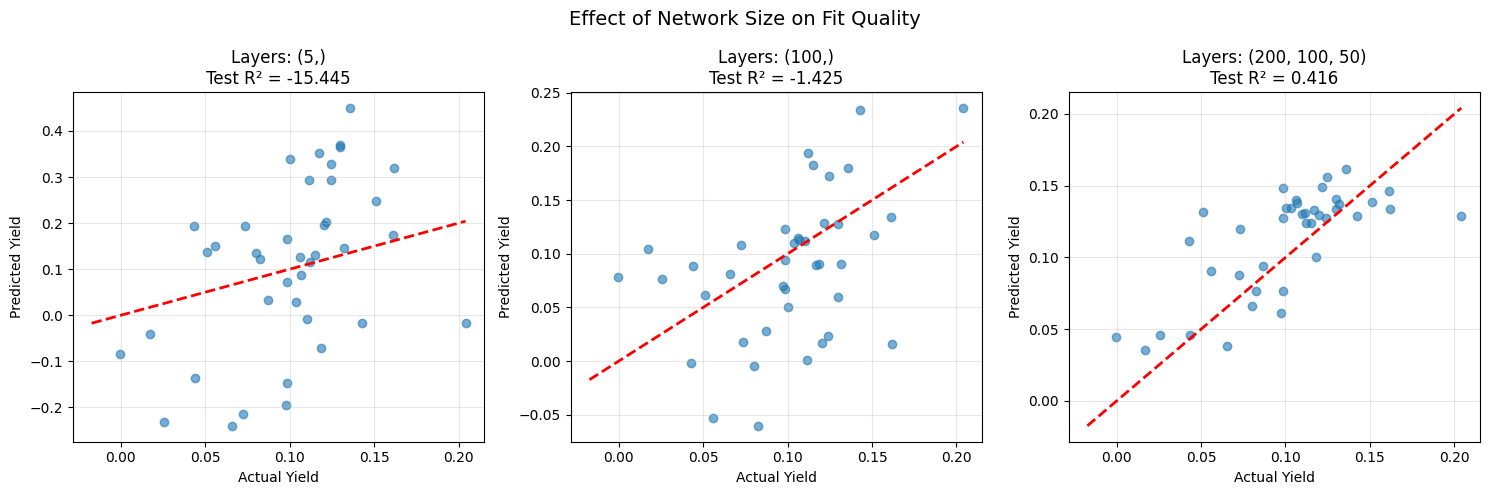

In [6]:
# Visualize: predicted vs actual for small, medium, large networks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, layers) in zip(axes, [("(5,)", (5,)), ("(100,)", (100,)), ("(200, 100, 50)", (200, 100, 50))]):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=layers, max_iter=1000, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2)
    ax.set_xlabel("Actual Yield")
    ax.set_ylabel("Predicted Yield")
    ax.set_title(f"Layers: {name}\nTest R² = {r2_score(y_test, y_pred):.3f}")
    ax.grid(True, alpha=0.3)

plt.suptitle("Effect of Network Size on Fit Quality", fontsize=14)
plt.tight_layout()
plt.show()

```{index} activation function, relu, tanh
```

### Activation Functions

The activation function determines the nonlinear transformation at each neuron:

| Function | Formula | Properties |
|----------|---------|------------|
| **relu** | $\max(0, x)$ | Fast, default choice, can "die" (output 0) |
| **tanh** | $\tanh(x)$ | Output in [-1, 1], zero-centered |
| **logistic** | $1/(1 + e^{-x})$ | Output in [0, 1], sigmoid shape |

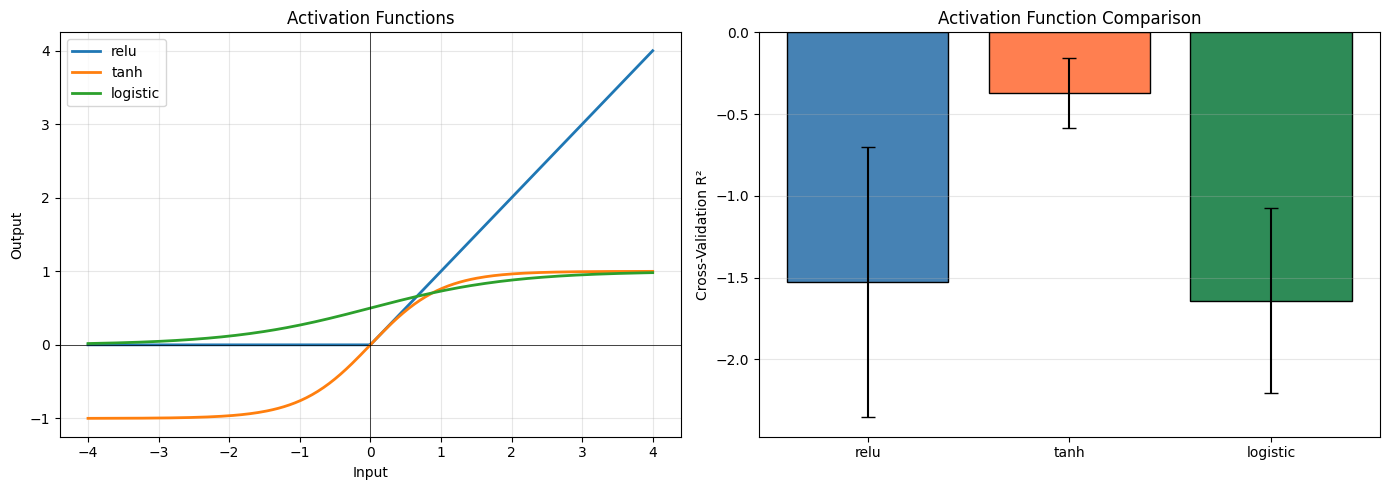

In [7]:
# Compare activation functions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: visualize the functions
x_act = np.linspace(-4, 4, 200)
axes[0].plot(x_act, np.maximum(0, x_act), label="relu", linewidth=2)
axes[0].plot(x_act, np.tanh(x_act), label="tanh", linewidth=2)
axes[0].plot(x_act, 1 / (1 + np.exp(-x_act)), label="logistic", linewidth=2)
axes[0].set_xlabel("Input")
axes[0].set_ylabel("Output")
axes[0].set_title("Activation Functions")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color="black", linewidth=0.5)
axes[0].axvline(x=0, color="black", linewidth=0.5)

# Right: compare performance
activation_scores = []
for act in ["relu", "tanh", "logistic"]:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(100,), activation=act,
                             max_iter=1000, random_state=42))
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
    activation_scores.append({"Activation": act, "Mean CV R²": scores.mean(), "Std": scores.std()})

act_df = pd.DataFrame(activation_scores)
axes[1].bar(act_df["Activation"], act_df["Mean CV R²"], yerr=act_df["Std"] * 2,
            capsize=5, edgecolor="black", color=["steelblue", "coral", "seagreen"])
axes[1].set_ylabel("Cross-Validation R²")
axes[1].set_title("Activation Function Comparison")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

```{index} feature scaling, StandardScaler, Pipeline
```

### Feature Scaling is Essential

Neural networks use gradient-based optimization. If features have very different scales (e.g., temperature in hundreds, pressure in single digits), gradients become unbalanced and training fails or converges very slowly.

**Always use `StandardScaler` in a `Pipeline`** — this is the same requirement as SVR (Module 09) and regularized regression (Module 08). The pipeline ensures scaling is applied correctly during cross-validation without data leakage.

In [8]:
# What happens without scaling?
nn_no_scale = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_no_scale.fit(X_train, y_train)

nn_with_scale = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])
nn_with_scale.fit(X_train, y_train)

print("Without scaling:")
print(f"  Train R²: {nn_no_scale.score(X_train, y_train):.4f}")
print(f"  Test R²:  {nn_no_scale.score(X_test, y_test):.4f}")
print(f"\nWith scaling:")
print(f"  Train R²: {nn_with_scale.score(X_train, y_train):.4f}")
print(f"  Test R²:  {nn_with_scale.score(X_test, y_test):.4f}")
print(f"\nScaling improved test R² by {nn_with_scale.score(X_test, y_test) - nn_no_scale.score(X_test, y_test):.4f}")

Without scaling:
  Train R²: -33507.9439
  Test R²:  -41198.6360

With scaling:
  Train R²: -1.0961
  Test R²:  -1.4254

Scaling improved test R² by 41197.2107


```{index} alpha regularization, early stopping, solver
```

### Alpha: L2 Regularization

The `alpha` parameter in `MLPRegressor` is L2 regularization — the same concept as Ridge regression from Module 08. It penalizes large weights to prevent overfitting:

- **Small alpha** (e.g., 0.0001): Minimal regularization, network can fit complex patterns (risk of overfitting)
- **Large alpha** (e.g., 1.0): Strong regularization, simpler model (risk of underfitting)

### Solver Choice

- **adam**: Good default for most problems. Adaptive learning rate, handles noise well.
- **lbfgs**: Quasi-Newton method. Works well on small datasets (<1000 samples). Deterministic.

### Early Stopping

Set `early_stopping=True` to automatically stop training when validation performance stops improving. This is a practical way to prevent overfitting without manually choosing `max_iter`.

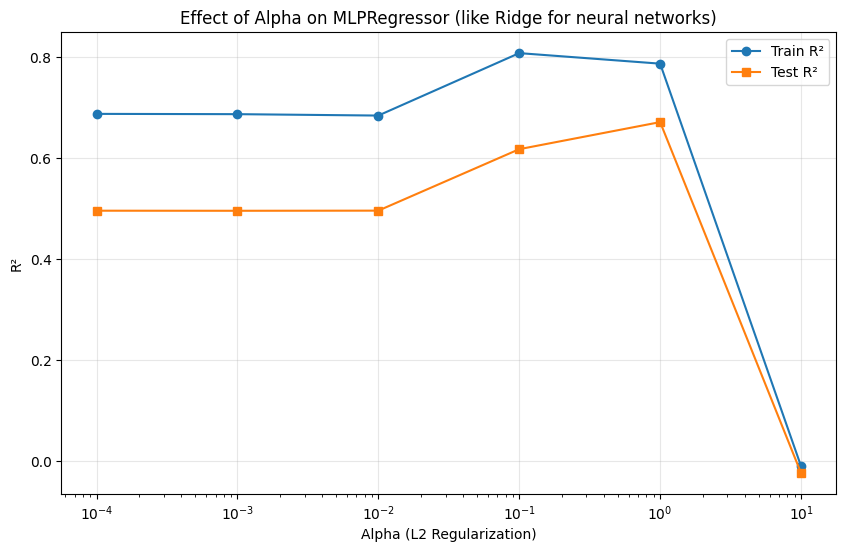

In [9]:
# Effect of alpha (L2 regularization)
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
alpha_results = []

for alpha in alphas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(100, 50), alpha=alpha,
                             max_iter=1000, random_state=42))
    ])
    pipe.fit(X_train, y_train)
    alpha_results.append({
        "alpha": alpha,
        "Train R²": pipe.score(X_train, y_train),
        "Test R²": pipe.score(X_test, y_test)
    })

alpha_df = pd.DataFrame(alpha_results)

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_df["alpha"], alpha_df["Train R²"], "o-", label="Train R²")
plt.semilogx(alpha_df["alpha"], alpha_df["Test R²"], "s-", label="Test R²")
plt.xlabel("Alpha (L2 Regularization)")
plt.ylabel("R²")
plt.title("Effect of Alpha on MLPRegressor (like Ridge for neural networks)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} Random Forest, decision tree, bagging
```

## Random Forest Preview

Before Module 10 covers ensemble methods in depth, let's preview **Random Forests** — one of the most practical and widely-used nonlinear methods.

### From Trees to Forests

A **decision tree** splits data using yes/no questions (e.g., "Is temperature > 400K?"). At each leaf node, it predicts the average of the training points that landed there. Trees naturally handle nonlinearity — each split creates a piecewise-constant approximation.

The problem: individual trees are **unstable and prone to overfitting**. Small changes in the training data can produce very different trees.

A **Random Forest** fixes this by:
1. Training many trees on random subsets of the data (bootstrap sampling)
2. Using random subsets of features at each split
3. Averaging all predictions

This reduces variance dramatically while maintaining the flexibility of trees.

### Key Hyperparameters

| Parameter | Effect | Typical Range |
|-----------|--------|---------------|
| `n_estimators` | Number of trees (more is better, just slower) | 100-500 |
| `max_depth` | Maximum tree depth (controls complexity) | 5-20 or None |
| `min_samples_split` | Minimum samples to split a node | 2-10 |
| `max_features` | Features considered at each split | "sqrt", "log2", or fraction |

### No Scaling Required

Unlike neural networks and SVR, **Random Forests do not need feature scaling**. Tree splits depend on thresholds, not distances or gradients, so the absolute scale of features doesn't matter.

In [10]:
# Random Forest on the same dataset — no scaling needed!
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("Random Forest (no scaling):")
print(f"  Train R²: {rf.score(X_train, y_train):.4f}")
print(f"  Test R²:  {rf.score(X_test, y_test):.4f}")

# Compare with our neural network
nn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])
nn_pipe.fit(X_train, y_train)

print(f"\nNeural Network (with scaling):")
print(f"  Train R²: {nn_pipe.score(X_train, y_train):.4f}")
print(f"  Test R²:  {nn_pipe.score(X_test, y_test):.4f}")

print("\nRandom Forest works well out of the box with minimal tuning!")
print("Module 10 covers ensemble methods (Random Forests, Gradient Boosting, XGBoost) in depth.")

Random Forest (no scaling):
  Train R²: 0.9669
  Test R²:  0.6441

Neural Network (with scaling):
  Train R²: -1.0961
  Test R²:  -1.4254

Random Forest works well out of the box with minimal tuning!
Module 10 covers ensemble methods (Random Forests, Gradient Boosting, XGBoost) in depth.


```{index} hyperparameter tuning, RandomizedSearchCV, GridSearchCV
```

## Hyperparameter Tuning Strategies

### The Challenge

Neural networks have many hyperparameters that interact in complex ways. The difference between a poorly tuned and well-tuned neural network can be enormous — often larger than the difference between algorithm choices.

### GridSearchCV Review

We used `GridSearchCV` in the previous lecture to tune SVR. It tries every combination on a predefined grid:

```python
param_grid = {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]}  # 9 combinations
```

**Problem**: With many hyperparameters, the grid grows exponentially. If you have 5 parameters with 5 values each, that's $5^5 = 3{,}125$ combinations, each requiring full cross-validation.

### RandomizedSearchCV: A Smarter Approach

Instead of trying every combination, **sample randomly** from the hyperparameter space:

1. Define probability distributions for each parameter
2. Sample `n_iter` random combinations
3. Evaluate each with cross-validation
4. Return the best

**Why random search often beats grid search** (Bergstra & Bengio, 2012):

- Grid search wastes evaluations on unimportant parameters
- If only 1-2 parameters really matter, random search explores more unique values of those parameters
- You control the compute budget directly with `n_iter`

### Choosing Distributions

Use `scipy.stats` distributions for continuous hyperparameters:

| Parameter Type | Distribution | Example |
|---------------|-------------|----------|
| Log-scale (alpha, learning rate) | `loguniform(a, b)` | `loguniform(1e-5, 1e-1)` |
| Linear-scale (layer sizes) | `randint(a, b)` | `randint(10, 200)` |
| Bounded continuous | `uniform(loc, scale)` | `uniform(0, 1)` |
| Categorical | list | `["relu", "tanh"]` |

In [11]:
# RandomizedSearchCV for MLPRegressor
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=1000, early_stopping=True, random_state=42))
])

# Define distributions for each hyperparameter
param_distributions = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": loguniform(1e-5, 1e-1),
    "mlp__learning_rate_init": loguniform(1e-4, 1e-2),
}

# Random search with 30 iterations (instead of exhaustive grid)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=30,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("RandomizedSearchCV Results:")
print(f"  Best parameters: {random_search.best_params_}")
print(f"  Best CV R²: {random_search.best_score_:.4f}")
print(f"  Test R²: {random_search.score(X_test, y_test):.4f}")

/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

RandomizedSearchCV Results:
  Best parameters: {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.0017912362571043657), 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': np.float64(0.0004066563313514797)}
  Best CV R²: 0.7452
  Test R²: 0.6139


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# Compare: GridSearchCV vs RandomizedSearchCV
# Grid search with a smaller, discrete grid
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.1],
    "mlp__learning_rate_init": [0.001, 0.01],
}

grid_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=1000, early_stopping=True, random_state=42))
])

start = time.time()
grid_search = GridSearchCV(grid_pipeline, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_time = time.time() - start

n_grid_combos = 1
for v in param_grid.values():
    n_grid_combos *= len(v)

print(f"GridSearchCV: {n_grid_combos} combinations, {grid_time:.1f}s")
print(f"  Best CV R²: {grid_search.best_score_:.4f}")
print(f"  Test R²:    {grid_search.score(X_test, y_test):.4f}")
print(f"\nRandomizedSearchCV: 30 iterations (from previous cell)")
print(f"  Best CV R²: {random_search.best_score_:.4f}")
print(f"  Test R²:    {random_search.score(X_test, y_test):.4f}")
print(f"\nRandom search explored 30 combinations vs Grid's {n_grid_combos}")

/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

GridSearchCV: 48 combinations, 1.3s
  Best CV R²: 0.7714
  Test R²:    0.7046

RandomizedSearchCV: 30 iterations (from previous cell)
  Best CV R²: 0.7452
  Test R²:    0.6139

Random search explored 30 combinations vs Grid's 48


```{index} KFold, RepeatedKFold, cross-validation strategies
```

### Cross-Validation Strategies

The default `cv=5` in scikit-learn uses `KFold` — split data into 5 parts, test on each. But a single 5-fold split can give different results depending on how the data was partitioned.

#### RepeatedKFold

`RepeatedKFold` repeats K-fold cross-validation multiple times with different random splits, then averages all scores. This reduces the variance of the CV estimate:

```python
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)  # 15 total fits
```

- `n_splits=5, n_repeats=1`: Standard 5-fold (5 fits)
- `n_splits=5, n_repeats=3`: Three repetitions (15 fits) — more stable estimate
- `n_splits=5, n_repeats=10`: Very stable estimate (50 fits) — useful for small datasets

**When to use RepeatedKFold**:
- Small datasets where fold composition matters more
- When comparing models with similar performance (need precise estimates)
- When you want confidence in your CV score

**Note**: For classification, `RepeatedStratifiedKFold` maintains class balance in each fold. For regression, shuffling in `KFold` is what matters.

In [13]:
# Compare CV score stability: KFold vs RepeatedKFold
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])

# Standard 5-fold (different random seeds give different scores)
kfold_scores_by_seed = []
for seed in range(10):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    kfold_scores_by_seed.append(scores.mean())

# RepeatedKFold (inherently more stable)
cv_repeated = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
repeated_scores = cross_val_score(pipe, X, y, cv=cv_repeated, scoring="r2")

print("Variability of 5-Fold CV across 10 different random splits:")
print(f"  Mean of means: {np.mean(kfold_scores_by_seed):.4f}")
print(f"  Std of means:  {np.std(kfold_scores_by_seed):.4f}")
print(f"  Range: [{np.min(kfold_scores_by_seed):.4f}, {np.max(kfold_scores_by_seed):.4f}]")

print(f"\nRepeatedKFold (5 splits x 3 repeats = 15 scores):")
print(f"  Mean: {repeated_scores.mean():.4f}")
print(f"  Std:  {repeated_scores.std():.4f}")
print(f"\nRepeatedKFold gives a single, more reliable estimate.")

Variability of 5-Fold CV across 10 different random splits:
  Mean of means: -1.5013
  Std of means:  0.0568
  Range: [-1.5853, -1.3956]

RepeatedKFold (5 splits x 3 repeats = 15 scores):
  Mean: -1.5408
  Std:  0.8292

RepeatedKFold gives a single, more reliable estimate.


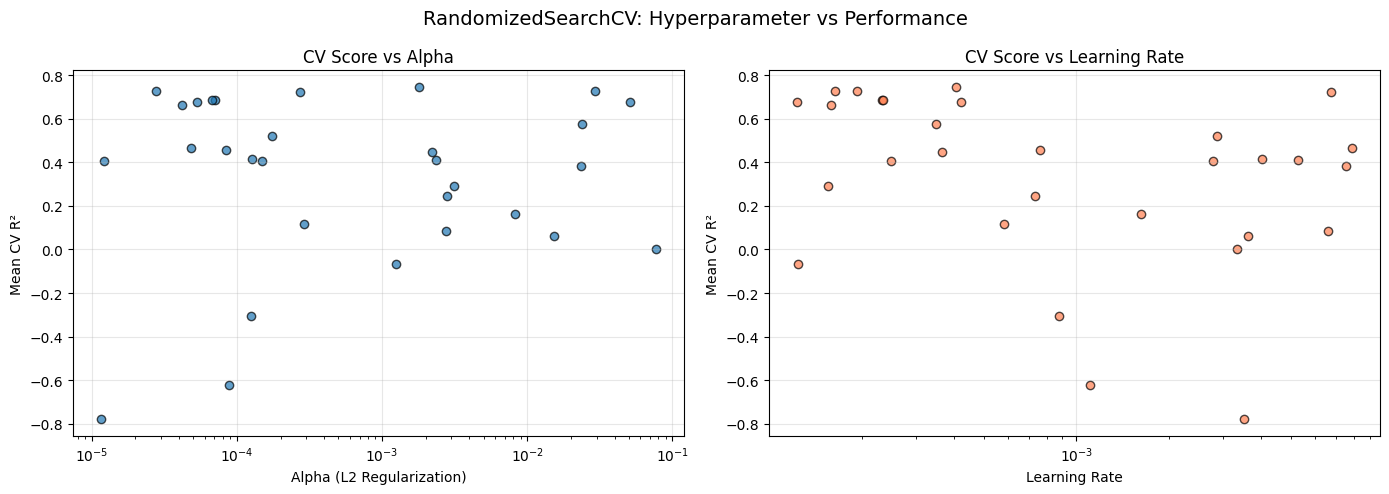

In [14]:
# Visualize RandomizedSearchCV results
results = pd.DataFrame(random_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: score vs alpha (log scale)
axes[0].scatter(results["param_mlp__alpha"].astype(float),
               results["mean_test_score"], alpha=0.7, edgecolors="black")
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha (L2 Regularization)")
axes[0].set_ylabel("Mean CV R²")
axes[0].set_title("CV Score vs Alpha")
axes[0].grid(True, alpha=0.3)

# Right: score vs learning rate (log scale)
axes[1].scatter(results["param_mlp__learning_rate_init"].astype(float),
               results["mean_test_score"], alpha=0.7, edgecolors="black", color="coral")
axes[1].set_xscale("log")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Mean CV R²")
axes[1].set_title("CV Score vs Learning Rate")
axes[1].grid(True, alpha=0.3)

plt.suptitle("RandomizedSearchCV: Hyperparameter vs Performance", fontsize=14)
plt.tight_layout()
plt.show()

```{index} model comparison
```

## Model Comparison on a Higher-Dimensional Problem

Let's compare all nonlinear methods on a more challenging dataset with 6 features: the `ensemble_process.csv` dataset from a catalytic reactor simulation.

In [15]:
# Load 6-feature catalyst process dataset
url_proc = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/ensemble_process.csv"
df_proc = pd.read_csv(url_proc)

feature_cols = ["temperature", "pressure", "catalyst_loading",
                "residence_time", "feed_ratio", "impurity_level"]
X_proc = df_proc[feature_cols].values
y_proc = df_proc["conversion"].values

X_tr, X_te, y_tr, y_te = train_test_split(X_proc, y_proc, test_size=0.2, random_state=42)

print(f"Dataset: {X_proc.shape[0]} samples, {X_proc.shape[1]} features")
print(f"Target: reactor conversion")

Dataset: 500 samples, 6 features
Target: reactor conversion


In [16]:
# Compare five nonlinear approaches
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Poly (deg=2) + Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("model", Ridge(alpha=1.0))
    ]),
    "SVR (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf", C=100))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
}

comparison = []
for name, model in models.items():
    start = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start
    
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    cv_scores = cross_val_score(model, X_proc, y_proc, cv=cv, scoring="r2")
    
    comparison.append({
        "Model": name,
        "Train R²": model.score(X_tr, y_tr),
        "Test R²": model.score(X_te, y_te),
        "CV R² (mean)": cv_scores.mean(),
        "CV R² (std)": cv_scores.std(),
        "Train Time (s)": train_time
    })

comp_df = pd.DataFrame(comparison)
print(comp_df.to_string(index=False))

               Model  Train R²   Test R²  CV R² (mean)  CV R² (std)  Train Time (s)
              Linear  0.384361  0.086325      0.303848     0.098320        0.001283
Poly (deg=2) + Ridge  0.536004  0.164005      0.387165     0.112790        0.000846
           SVR (RBF) -3.016716 -3.880723     -3.038570     1.073372        0.000573
      Neural Network -0.586620 -2.355595     -2.426512     1.128295        0.017616
       Random Forest  0.899099  0.174583      0.359042     0.104709        0.040096


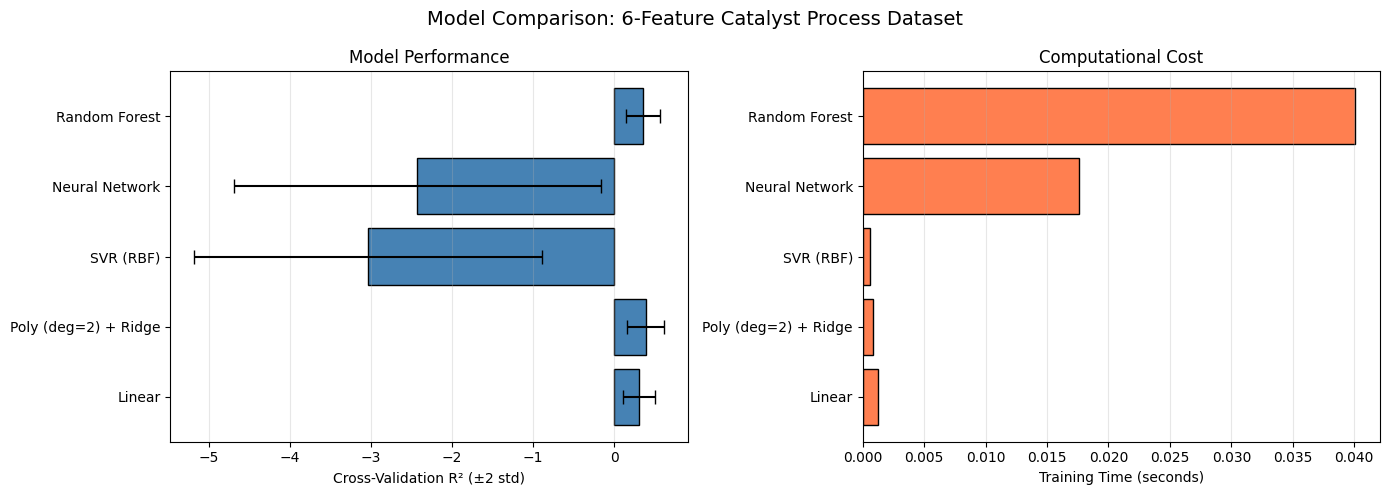

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: CV R² with error bars
axes[0].barh(comp_df["Model"], comp_df["CV R² (mean)"],
             xerr=comp_df["CV R² (std)"] * 2, capsize=5,
             edgecolor="black", color="steelblue")
axes[0].set_xlabel("Cross-Validation R² (±2 std)")
axes[0].set_title("Model Performance")
axes[0].grid(True, alpha=0.3, axis="x")

# Right: Training time
axes[1].barh(comp_df["Model"], comp_df["Train Time (s)"],
             edgecolor="black", color="coral")
axes[1].set_xlabel("Training Time (seconds)")
axes[1].set_title("Computational Cost")
axes[1].grid(True, alpha=0.3, axis="x")

plt.suptitle("Model Comparison: 6-Feature Catalyst Process Dataset", fontsize=14)
plt.tight_layout()
plt.show()

### When to Use Which Method

| Method | Scaling Needed? | Interpretable? | Tuning Difficulty | Best For |
|--------|:-:|:-:|:-:|----------|
| Linear/Ridge | Yes | High | Low | Baseline, few features |
| Polynomial + Ridge | Yes | Medium | Low-Medium | Known polynomial form, few features |
| SVR (RBF) | Yes | Low | Medium | Unknown nonlinearity, small datasets |
| Neural Network | Yes | Low | High | Complex patterns, enough data |
| Random Forest | No | Medium | Low | Good default, handles interactions |

**Practical advice**: Start with Random Forest as a quick baseline (minimal tuning needed), then try neural networks or SVR if you need better performance and have time to tune.

In [18]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("quizzes/neural-networks-hyperparameter-tuning-quiz.json")

/Users/jkitchin/Dropbox/uv/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

## Recommended Reading

1. **[Scikit-learn Neural Network Models](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)** - Official documentation on MLPRegressor and MLPClassifier, including practical tips on architecture selection and preprocessing.

2. **[Random Search for Hyper-Parameter Optimization (Bergstra & Bengio, 2012)](https://jmlr.org/papers/v13/bergstra12a.html)** - The key paper showing that random search is more efficient than grid search, especially when only a few hyperparameters matter.

3. **[Scikit-learn Model Selection and Evaluation](https://scikit-learn.org/stable/model_selection.html)** - Comprehensive guide to cross-validation strategies, hyperparameter tuning, and model comparison.

4. **[Neural Networks and Deep Learning (Nielsen, free online)](http://neuralnetworksanddeeplearning.com/)** - Accessible introduction to neural network concepts including backpropagation, activation functions, and regularization.

5. **[An Introduction to Statistical Learning, Chapter 10](https://www.statlearning.com/)** - Covers deep learning fundamentals with clear explanations of network architecture and training.

## Summary

### What We Learned

| Topic | Key Takeaway |
|-------|-------------|
| **MLPRegressor** | Universal approximator — flexible but needs careful tuning |
| **Hidden layers** | More neurons = more capacity, but risk of overfitting |
| **Feature scaling** | Essential for NNs and SVR; not needed for Random Forest |
| **Alpha** | L2 regularization — same concept as Ridge, applied to network weights |
| **Random Forest** | Strong baseline with minimal tuning; covered in depth in Module 10 |
| **RandomizedSearchCV** | Efficient alternative to grid search for large parameter spaces |
| **RepeatedKFold** | More stable CV estimates through repeated splitting |

### The Tuning Lesson

A well-tuned simple model often beats a poorly tuned complex model. The algorithm isn't magic — **systematic tuning is essential**. This is especially true for neural networks, which have many interacting hyperparameters.

### Common Pitfalls

- Forgetting to scale features for neural networks (use Pipeline!)
- Using default hyperparameters and expecting good results
- Exhaustive grid search when random search would be faster and equally effective
- Trusting a single train/test split instead of cross-validation
- Choosing the most complex model when a simpler one performs comparably

## Next Steps

Module 10 covers **ensemble methods** in depth — Random Forests, Gradient Boosting, and XGBoost. These combine multiple models for even better predictions, and they'll prove crucial in the ongoing catalyst investigation.

---

## The Catalyst Crisis: Chapter 9b - "The Humbling"

*A story about the gap between promise and practice*

---

Maya was excited. "Neural networks. Universal approximators. They can learn *any* function."

She'd read three papers that morning and was ready to solve the catalyst mystery once and for all. She opened a notebook, imported `MLPRegressor`, and fed it the reactor data.

The first result: R-squared of 0.12.

"That can't be right." She re-ran it. Same result. She added more neurons. 0.15. She added more layers. 0.08. She doubled everything. 0.03.

"It's getting *worse*?"

Alex looked over her shoulder. "Did you scale the features?"

Maya checked. Temperature was in the hundreds, pressure in the tens, impurity levels in the hundredths. The network was drowning in scale differences.

She added `StandardScaler` in a pipeline. R-squared jumped to 0.45. Better, but not the breakthrough she'd hoped for.

"Try different architectures," Sam suggested. "And different learning rates. And alpha values."

Three hours later, Maya had a spreadsheet of 47 experiments. Some configurations scored 0.50. Others scored 0.10. One bizarre combination of tanh activation with a tiny learning rate scored 0.55. Nothing was consistent.

"I thought neural networks were supposed to be powerful," she said, frustration creeping in.

"They are," Alex said. "But power without tuning is just chaos. A badly tuned neural network is worse than a simple linear model."

Professor Pipeline, passing through the lab, overheard. "What have you tried?"

"Everything." Maya gestured at the spreadsheet.

"No. You've tried *random things*. That's not the same as everything." He sat down. "You need `RandomizedSearchCV`. Define the space, set a budget, let the search be systematic. And use `RepeatedKFold` so your scores are stable."

Maya refactored her code. The randomized search ran thirty configurations in minutes. The best scored 0.52, repeatable across folds. Not spectacular, but honest.

"The algorithm isn't magic," Alex said. "It's a tool. And tools need to be calibrated."

Maya nodded slowly. She'd been humbled—not by the problem, but by her own assumptions. The neural network could learn anything in theory. In practice, it needed help: the right scale, the right architecture, the right regularization. Systematic tuning, not hopeful guessing.

"You know what worked almost as well with zero tuning?" Sam showed her a Random Forest result. R-squared of 0.48, out of the box.

Maya laughed. "So the fancy model barely beats the simple one?"

"For now," Professor Pipeline said. "But the ensemble methods in our next lesson—when you combine many models together—that's when things get interesting. That's when patterns emerge that no single model can find alone."

He left. Maya stared at her results. The catalyst mystery wasn't solved. But she'd learned something that might matter more: **the gap between a model's theoretical power and its practical performance is bridged by careful, systematic tuning.**

She added to the mystery board: *Tuning matters more than algorithm choice. Next: ensemble methods.*

---

*Continue to Module 10 to discover the power of ensemble methods...*